# Sentiment analysis of Portuguese data using [DistilBERT](https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student) and [mmBERT Small Multilingual Sentiment Model](https://huggingface.co/clapAI/mmBERT-small-multilingual-sentiment)

This notebook tests two models of sentiment analysis for a dataset in the Portuguese language using Python 3.12.12. It covers the steps of data download and cleaning, model loading, sentiment analysis application and evaluation.

**Mariana Gonçalves da Costa** [Programa de Pós-Graduação em Informática/UFRJ] \
**Matheus do Ó Santos Tiburcio** [Instituto de Computação/UFRJ]

Last updated: 28 Jan 2026

## Loading Libraries

In [ ]:
import os
import pandas as pd
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import warnings
warnings.filterwarnings("ignore")# Import dependencies

## Data Download and Cleaning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/Mestrado/Dataset-analise-sentimentos-PT")

path = "/content/drive/MyDrive/Mestrado/Dataset-analise-sentimentos-PT"

print(os.getcwd())  # Print the work directory

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Mestrado/Dataset-analise-sentimentos-PT


In [ ]:
dados_ptbr = pd.read_csv("./pt_tweet_sent_br (com label).tsv", sep="\t", header = None).drop([0], axis=1) # 10109 rows x 2 columns
dados_pteu = pd.read_csv("./pt_twitter_sentiment (com label).tsv", sep="\t", header = None).drop([0], axis=1) # 145197 rows x 2 columns

In [ ]:
dados_pteu.head()

,1,2
0,!!! JOB OPPORTUNITY: A empresa SPOTCOM procura...,neutral
1,# 'Estou convencido que podemos passar em prim...,positive
2,# @ Passeio Marítimo de Oeiras http://t.co/mAa...,negative
3,"# Angola, Brasil e Portugal na corrida ao BES ...",negative
4,# Ao Som De Nx Zero ...,negative


In [ ]:
# Extracts the occurances of "morrer de/a" and "chorar de/a" using a regular expression in the second column of the dataset
# The results are used to filter the original dataset to maintain their labels

dados_booleanos = dados_ptbr[1].str.contains(r"\b(morr|chor)\w*\s+(de|a)\b", case=False, regex=True)
dados_ptbr_filtrado = dados_ptbr[dados_booleanos] # 30 rows
dados_ptbr_filtrado

,1,2
661,"#MaisVoce 😀😁😂😅😄 Ana,volta ás panelas,passar ro...",positive
671,#MaisVocê Amo O @Louro_Jose Ele é show morren...,positive
1267,#VideoShowAoVivo Cadê a Sofia ?!?! Melhor ...,positive
1446,#VideoShowAoVivo Sentir medo é morrer a cada m...,neutral
2384,@masterchefbr #MasterChefBR Nesta prova o meno...,neutral
2831,AIIINNN cara!!! Eu tô pra morrer de inveja ven...,negative
3364,Apenas morrendo de amores por esse novo álbum ...,positive
3868,Chorei de chegar soluçar quando vi o que acont...,negative
3928,Começar o dia com a @ANAMARIABRAGA vestida de ...,neutral
4454,"Eles morrem de rir tb,taquem falha nossa de No...",neutral


In [ ]:
dados_booleanos_eu = dados_pteu[1].str.contains(r"\b(morr|chor)\w*\s+(de|a)\b", case=False, regex=True)
dados_pteu_filtrado = dados_pteu[dados_booleanos_eu] # 301 rows

In [ ]:
# The datasets are transformed in dictionaries containing the cases and labels

preproc_mwes_ptbr = {"cases":list(dados_ptbr_filtrado[1]), "labels":list(dados_ptbr_filtrado[2])}
preproc_mwes_ptbr["cases"]

['#MaisVoce 😀😁😂😅😄 Ana,volta ás panelas,passar roupa não é o seu forte!😂😁😃😆 morrendo de rir!💋',
 '#MaisVocê Amo O @Louro_Jose  Ele é show morrendo de rir😂😂😂',
 '#VideoShowAoVivo    Cadê  a Sofia ?!?! Melhor pessoa ela morro de rir ❤ vcs três fica perfeito 😘',
 '#VideoShowAoVivo Sentir medo é morrer a cada minuto ... só ouvir verdades',
 '@masterchefbr #MasterChefBR Nesta prova o menos será mais,para agradar os atletas!!E eu já estou morrendo de fome!😣',
 'AIIINNN cara!!! Eu tô pra morrer de inveja vendo a @jublackpower agarrando o meu papacito @maluma💖😭 #TheNoite @DaniloGentili',
 'Apenas morrendo de amores por esse novo álbum do @nando_reis e ansiosa pelo próximo show! #Encontro',
 'Chorei de chegar soluçar quando vi o que aconteceu com o @MChefVitorB #MasterChefBR',
 'Começar o dia com a @ANAMARIABRAGA vestida de unicórnio é mesmo surreal. Morrendo de rir! #MAISVOCÊ',
 'Eles morrem de rir tb,taquem falha nossa de Novo Mundo,por favor. #VideoShowAoVivo',
 'Eu comu mas não morro de amor

In [ ]:
preproc_mwes_pteu = {"cases":list(dados_pteu_filtrado[1]), "labels":list(dados_pteu_filtrado[2])}
preproc_mwes_pteu["cases"]

['#QuemNunca chorou de raiva?',
 '#SeTensIrmãos quando estão juntos estão sempre a discutir // estão separados morrem de saudades',
 '#WePrayForJustin ok chego ao twitter e vejo isto... Seriio? Morri de susto -.- Ele vai ficar melhor :)',
 "''E o amor morre numa altura em que já ninguém morre de amor''",
 "'Antes morrer a lutar do que morrer a fugir.'",
 "'Espero que tenhas mudado a minha opinião sobre mim. Mudaste?' 'Não' chorei a rir",
 "'não existe um sempre, mas morreria a tentá-lo contigo' vtf",
 ':oooo chorand a foi tăo fofa com o comentário',
 '@Bubaaas Lol espero que morras a ser violado ! unf',
 '@C0rdeCaramel0 eu tou morrendo de sono ja :c',
 '@HenriqueeN vou morrer a rir tds os dias qnd for p a escola',
 '@Jezz____ omg estou a chorar de tanto rir',
 '@MafaldaAlmeida9 É de chorar a rir! :-)',
 '@Maggie_is_sweet Eu estou a morrer de calor!',
 '@Marianasimoes10 infelizmente vou fazer vais ver sou um dançarino xii vais morrer a rir',
 '@ObservatorioH Daniel Muller.  Morreu de ca

## Export the new dataset in .csv

In [ ]:
def export_data(data, filename):
  # Convert the dictionary to a pandas DataFrame
  df = pd.DataFrame(data)

  # Export to CSV
  df.to_csv(filename, index=False, encoding='utf-8')

  print(f"Data has been successfully exported to {filename}")

In [ ]:
export_data(preproc_mwes_pteu, "mwes_pteu.csv")

Data has been successfully exported to mwes_pteu.csv


In [ ]:
export_data(preproc_mwes_ptbr, "mwes_ptbr.csv")

Data has been successfully exported to mwes_ptbr.csv


## Import the cleaned datasets

In [ ]:
mwes_ptbr_table = pd.read_csv('mwes_ptbr_cleaned.csv')
mwes_pteu_table = pd.read_csv('mwes_pteu_cleaned.csv')

In [ ]:
mwes_ptbr = {"cases":list(mwes_ptbr_table["cases"]), "labels":list(mwes_ptbr_table["labels"])}
mwes_ptbr["cases"]

['#MaisVoce 😀😁😂😅😄 Ana,volta ás panelas,passar roupa não é o seu forte!😂😁😃😆 morrendo de rir!💋',
 '#MaisVocê Amo O @Louro_Jose  Ele é show morrendo de rir😂😂😂',
 '#VideoShowAoVivo    Cadê  a Sofia ?!?! Melhor pessoa ela morro de rir ❤ vcs três fica perfeito 😘',
 '#VideoShowAoVivo Sentir medo é morrer a cada minuto ... só ouvir verdades',
 '@masterchefbr #MasterChefBR Nesta prova o menos será mais,para agradar os atletas!!E eu já estou morrendo de fome!😣',
 'AIIINNN cara!!! Eu tô pra morrer de inveja vendo a @jublackpower agarrando o meu papacito @maluma💖😭 #TheNoite @DaniloGentili',
 'Apenas morrendo de amores por esse novo álbum do @nando_reis e ansiosa pelo próximo show! #Encontro',
 'Chorei de chegar soluçar quando vi o que aconteceu com o @MChefVitorB #MasterChefBR',
 'Começar o dia com a @ANAMARIABRAGA vestida de unicórnio é mesmo surreal. Morrendo de rir! #MAISVOCÊ',
 'Eles morrem de rir tb,taquem falha nossa de Novo Mundo,por favor. #VideoShowAoVivo',
 'Eu comu mas não morro de amor

In [ ]:
mwes_pteu = {"cases":list(mwes_pteu_table["cases"]), "labels":list(mwes_pteu_table["labels"])}
mwes_pteu["cases"]

['#QuemNunca chorou de raiva?',
 '#SeTensIrmãos quando estão juntos estão sempre a discutir // estão separados morrem de saudades',
 '#WePrayForJustin ok chego ao twitter e vejo isto... Seriio? Morri de susto -.- Ele vai ficar melhor :)',
 "''E o amor morre numa altura em que já ninguém morre de amor''",
 "'Antes morrer a lutar do que morrer a fugir.'",
 "'Espero que tenhas mudado a minha opinião sobre mim. Mudaste?' 'Não' chorei a rir",
 '@C0rdeCaramel0 eu tou morrendo de sono ja :c',
 '@HenriqueeN vou morrer a rir tds os dias qnd for p a escola',
 '@Jezz____ omg estou a chorar de tanto rir',
 '@MafaldaAlmeida9 É de chorar a rir! :-)',
 '@Maggie_is_sweet Eu estou a morrer de calor!',
 '@Marianasimoes10 infelizmente vou fazer vais ver sou um dançarino xii vais morrer a rir',
 '@ObservatorioH Daniel Muller.  Morreu de cancro com 50 e poucos anos.',
 '@RittaDuartee O que morri a rir naquele almoço! Ficamos piratingas a ver o Felix :p',
 '@Tarequinho18 nepia mas já me basta estar a morrer

In [ ]:
mwes_pteu_labels = mwes_pteu["labels"]
mwes_ptbr_labels = mwes_ptbr["labels"]

## DistilBERT: [Multilingual cased sentiments](https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student)

## Import and installing the model

In [ ]:
# Install dependencies
!pip install -q torch==2.9 transformers==4.55.0

In [ ]:
model = pipeline(model="lxyuan/distilbert-base-multilingual-cased-sentiments-student", top_k=None)

Device set to use cpu


## Running Model

In [ ]:
def run_model (lista):
  results_list = []
  for sentence in lista:
    labels = model(sentence)
    if labels:
      inner_labels = labels[0]
      results_list.append({'sentence': sentence, 'result': inner_labels[0]})
  return results_list

In [ ]:
results_DistilBERT_ptbr = run_model(mwes_ptbr["cases"])
results_DistilBERT_ptbr

[{'sentence': '#MaisVoce 😀😁😂😅😄 Ana,volta ás panelas,passar roupa não é o seu forte!😂😁😃😆 morrendo de rir!💋',
  'result': {'label': 'negative', 'score': 0.7887843251228333}},
 {'sentence': '#MaisVocê Amo O @Louro_Jose  Ele é show morrendo de rir😂😂😂',
  'result': {'label': 'negative', 'score': 0.4329986870288849}},
 {'sentence': '#VideoShowAoVivo    Cadê  a Sofia ?!?! Melhor pessoa ela morro de rir ❤ vcs três fica perfeito 😘',
  'result': {'label': 'negative', 'score': 0.6156063675880432}},
 {'sentence': '#VideoShowAoVivo Sentir medo é morrer a cada minuto ... só ouvir verdades',
  'result': {'label': 'negative', 'score': 0.5491132140159607}},
 {'sentence': '@masterchefbr #MasterChefBR Nesta prova o menos será mais,para agradar os atletas!!E eu já estou morrendo de fome!😣',
  'result': {'label': 'negative', 'score': 0.4824746251106262}},
 {'sentence': 'AIIINNN cara!!! Eu tô pra morrer de inveja vendo a @jublackpower agarrando o meu papacito @maluma💖😭 #TheNoite @DaniloGentili',
  'result':

In [ ]:
# Extracting labels using a list comprehension
results_DistilBERT_ptbr_labels = [item['result']['label'] for item in results_DistilBERT_ptbr]

print(results_DistilBERT_ptbr_labels)

['negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'positive', 'negative', 'negative', 'neutral', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive']


In [ ]:
results_DistilBERT_pteu = run_model(mwes_pteu["cases"])
results_DistilBERT_pteu

[{'sentence': '#QuemNunca chorou de raiva?',
  'result': {'label': 'negative', 'score': 0.639542818069458}},
 {'sentence': '#SeTensIrmãos quando estão juntos estão sempre a discutir // estão separados morrem de saudades',
  'result': {'label': 'negative', 'score': 0.45021212100982666}},
 {'sentence': '#WePrayForJustin ok chego ao twitter e vejo isto... Seriio? Morri de susto -.- Ele vai ficar melhor :)',
  'result': {'label': 'positive', 'score': 0.5742908716201782}},
 {'sentence': "''E o amor morre numa altura em que já ninguém morre de amor''",
  'result': {'label': 'positive', 'score': 0.567615270614624}},
 {'sentence': "'Antes morrer a lutar do que morrer a fugir.'",
  'result': {'label': 'negative', 'score': 0.6261975169181824}},
 {'sentence': "'Espero que tenhas mudado a minha opinião sobre mim. Mudaste?' 'Não' chorei a rir",
  'result': {'label': 'negative', 'score': 0.4006178379058838}},
 {'sentence': '@C0rdeCaramel0 eu tou morrendo de sono ja :c',
  'result': {'label': 'positi

In [ ]:
# Extracting labels using a list comprehension
results_DistilBERT_pteu_labels = [item['result']['label'] for item in results_DistilBERT_pteu]

print(results_DistilBERT_pteu_labels)

['negative', 'negative', 'positive', 'positive', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'positive', 'ne

## mmBERT: [Multilingual cased sentiments](https://huggingface.co/clapAI/mmBERT-small-multilingual-sentiment)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Import dependencies
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
print(f'Device={device}, dtype={dtype}')

Device=cpu, dtype=torch.float16


In [ ]:
model_id = "clapAI/mmBERT-small-multilingual-sentiment"

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    torch_dtype=dtype,
    # Uncomment if device supports FA2
    # attn_implementation="flash_attention_2"
)

model.to(device)
model.eval()

# Retrieve labels from the model's configuration
id2label = model.config.id2label

In [ ]:
texts_br = mwes_ptbr["cases"]
texts_eu = mwes_pteu["cases"]

In [ ]:
def run_second_model(texts):
  predictions = []
  for i in texts:
    inputs = tokenizer(i, return_tensors="pt").to(device)
    with torch.inference_mode():
      outputs = model(**inputs)
      prediction = id2label[outputs.logits.argmax(dim=-1).item()]
      predictions.append(prediction)
    print(f"Text: {i} | Prediction: {prediction}")

  return predictions

In [ ]:
results_BERT_ptbr = run_second_model(texts_br)
results_BERT_ptbr

Text: #MaisVoce 😀😁😂😅😄 Ana,volta ás panelas,passar roupa não é o seu forte!😂😁😃😆 morrendo de rir!💋 | Prediction: positive
Text: #MaisVocê Amo O @Louro_Jose  Ele é show morrendo de rir😂😂😂 | Prediction: positive
Text: #VideoShowAoVivo    Cadê  a Sofia ?!?! Melhor pessoa ela morro de rir ❤ vcs três fica perfeito 😘 | Prediction: positive
Text: #VideoShowAoVivo Sentir medo é morrer a cada minuto ... só ouvir verdades | Prediction: negative
Text: @masterchefbr #MasterChefBR Nesta prova o menos será mais,para agradar os atletas!!E eu já estou morrendo de fome!😣 | Prediction: negative
Text: AIIINNN cara!!! Eu tô pra morrer de inveja vendo a @jublackpower agarrando o meu papacito @maluma💖😭 #TheNoite @DaniloGentili | Prediction: negative
Text: Apenas morrendo de amores por esse novo álbum do @nando_reis e ansiosa pelo próximo show! #Encontro | Prediction: positive
Text: Chorei de chegar soluçar quando vi o que aconteceu com o @MChefVitorB #MasterChefBR | Prediction: negative
Text: Começar o dia co

['positive',
 'positive',
 'positive',
 'negative',
 'negative',
 'negative',
 'positive',
 'negative',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'positive',
 'positive']

In [ ]:
results_BERT_pteu = run_second_model(texts_eu)
results_BERT_pteu

Text: #QuemNunca chorou de raiva? | Prediction: neutral
Text: #SeTensIrmãos quando estão juntos estão sempre a discutir // estão separados morrem de saudades | Prediction: negative
Text: #WePrayForJustin ok chego ao twitter e vejo isto... Seriio? Morri de susto -.- Ele vai ficar melhor :) | Prediction: negative
Text: ''E o amor morre numa altura em que já ninguém morre de amor'' | Prediction: neutral
Text: 'Antes morrer a lutar do que morrer a fugir.' | Prediction: positive
Text: 'Espero que tenhas mudado a minha opinião sobre mim. Mudaste?' 'Não' chorei a rir | Prediction: neutral
Text: @C0rdeCaramel0 eu tou morrendo de sono ja :c | Prediction: neutral
Text: @HenriqueeN vou morrer a rir tds os dias qnd for p a escola | Prediction: positive
Text: @Jezz____ omg estou a chorar de tanto rir | Prediction: negative
Text: @MafaldaAlmeida9 É de chorar a rir! :-) | Prediction: negative
Text: @Maggie_is_sweet Eu estou a morrer de calor! | Prediction: positive
Text: @Marianasimoes10 infelizmente

['neutral',
 'negative',
 'negative',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'negative',
 'negative',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'negative',
 'positive',
 'negative',
 'neutral',
 'negative',
 'negative',
 'positive',
 'negative',
 'positive',
 'negative',
 'neutral',
 'neutral',
 'negative',
 'neutral',
 'positive',
 'positive',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'neutral',
 'negative',
 'neutral',
 'negative',
 'neutral',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'neutral',
 'negative',
 'positive',
 'negative',
 'negative',
 'neutral',
 'neutral',
 'negative',
 'neutral',
 'positive',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'n

## Validation

In [ ]:
def hits(lista_a, lista_b):
  ''' Returns the number of correct labels by compairing the two lists.
  The lists must have the same length.
  Input: list of target labels and list of predicted labels.
  Output: number of correct labels.
  '''
    hits = 0
    # Ensure both lists have the same length to avoid index errors
    for i in range(min(len(lista_a), len(lista_b))):
        if lista_a[i] == lista_b[i]:
            hits += 1
    return hits

In [ ]:
hits(results_BERT_pteu, mwes_pteu_labels)

139

In [ ]:
hits(results_BERT_ptbr, mwes_ptbr_labels)

23

In [ ]:
hits(results_DistilBERT_pteu_labels, mwes_pteu_labels)

123

In [ ]:
hits(results_DistilBERT_ptbr_labels, mwes_ptbr_labels)

16

In [ ]:
# The classification report is done using the classification report function from sklearn metrics.
# We apply this function separately to the results from the Brazilian and European Portuguese from both models

from sklearn.metrics import classification_report

target_names = ['negative', 'neutral', 'positive']

classification_DistilBERT_ptbr = classification_report(mwes_ptbr_labels, results_DistilBERT_ptbr_labels, target_names=target_names)
print("Classification Report of DistilBERT PT-BR: \n")
print(classification_DistilBERT_ptbr)

classification_DistilBERT_pteu = classification_report(mwes_pteu_labels, results_DistilBERT_pteu_labels, target_names=target_names)
print("Classification Report of DistilBERT PT-EU: \n")
print(classification_DistilBERT_pteu)

classification_BERT_ptbr = classification_report(mwes_ptbr_labels, results_BERT_ptbr, target_names=target_names)
print("Classification Report of mmBERT PT-BR:\n")
print(classification_BERT_ptbr)

classification_BERT_pteu = classification_report(mwes_pteu_labels, results_BERT_pteu, target_names=target_names)
print("Classification Report of mmBERT PT-EU:\n")
print(classification_BERT_pteu)

Classification Report of DistilBERT PT-BR: 

              precision    recall  f1-score   support

    negative       0.21      0.75      0.33         4
     neutral       1.00      0.20      0.33         5
    positive       0.92      0.63      0.75        19

    accuracy                           0.57        28
   macro avg       0.71      0.53      0.47        28
weighted avg       0.84      0.57      0.62        28

Classification Report of DistilBERT PT-EU: 

              precision    recall  f1-score   support

    negative       0.46      0.95      0.62       109
     neutral       1.00      0.01      0.03        76
    positive       0.58      0.25      0.35        73

    accuracy                           0.48       258
   macro avg       0.68      0.40      0.33       258
weighted avg       0.65      0.48      0.37       258

Classification Report of mmBERT PT-BR:

              precision    recall  f1-score   support

    negative       0.50      0.75      0.60         4

In [ ]:
mwes_labels = mwes_ptbr_labels + mwes_pteu_labels
DistilBERT_labels = results_DistilBERT_ptbr_labels + results_DistilBERT_pteu_labels
BERT_labels = results_BERT_ptbr + results_BERT_pteu

In [ ]:
classification_DistilBERT = classification_report(mwes_labels, DistilBERT_labels, target_names=target_names)
print("Classification Report of DistilBERT: \n")
print(classification_DistilBERT_ptbr)

classification_BERT = classification_report(mwes_labels, BERT_labels, target_names=target_names)
print("Classification Report of mmBERT:\n")
print(classification_BERT)

Classification Report of DistilBERT: 

              precision    recall  f1-score   support

    negative       0.21      0.75      0.33         4
     neutral       1.00      0.20      0.33         5
    positive       0.92      0.63      0.75        19

    accuracy                           0.57        28
   macro avg       0.71      0.53      0.47        28
weighted avg       0.84      0.57      0.62        28

Classification Report of mmBERT:

              precision    recall  f1-score   support

    negative       0.53      0.84      0.65       113
     neutral       0.35      0.20      0.25        81
    positive       0.84      0.55      0.67        92

    accuracy                           0.57       286
   macro avg       0.57      0.53      0.52       286
weighted avg       0.58      0.57      0.54       286



In [ ]:
import matplotlib.pyplot as plt

In [ ]:
report_lines = classification_DistilBERT.strip().split("\n")
headers = ["Class", "Precision", "Recall", "F1-Score", "Support"]

# Parse each line
data = []
for line in report_lines[2:]:  # Skip the first two lines (header)
    columns = line.split()
    if len(columns) == 5:  # Regular row (negative, neutral, positive)
        data.append(columns)
    elif len(columns) == 4:  # Special row (accuracy, avg rows)
        columns.insert(0, "accuracy" if "accuracy" in columns[0] else columns[0])
        data.append(columns)

# Convert the list of data into a DataFrame
df = pd.DataFrame(data, columns=headers)

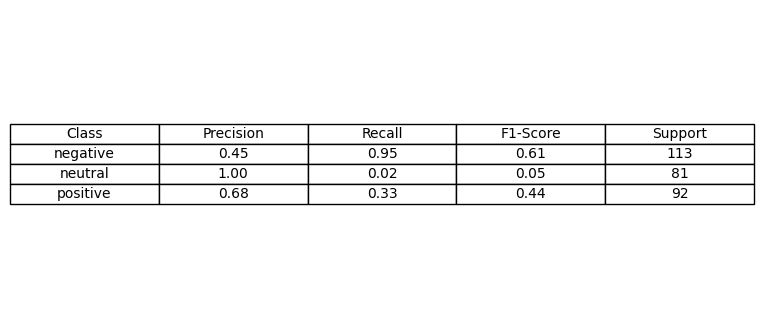

In [ ]:
# Create a figure and axis for plotting the table
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust the size as needed
ax.axis('off')  # Turn off the axis

# Create the table
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')

# Adjust table font size and styling
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Adjust scaling to fit the content

# Save the table as a PNG image
plt.savefig('table_plot2.png', bbox_inches='tight', dpi=300)

# Display the plot (optional)
plt.show()

------------------

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
def plotConfusionMatrix(predictions, y, labels, title="Confusion Matrix", normalize=False, path=""):
    '''
    Plots the confusion matrix for the predictions of a given model.
    Input:
    predictions made by the model;
    original classes of the instances;
    class names (for printing in the confusion matrix plot)
    '''

    conf = confusion_matrix(y, predictions)
    if normalize == True:
        conf = conf.astype("float")
        for i in range(conf.shape[0]):
            conf[i] = conf[i] / (conf[i].sum())
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(title)
    ConfusionMatrixDisplay(conf, display_labels=labels).plot(ax=ax)
    if path is not "":
      plt.savefig(path)
    return

In [ ]:
labels = {"distilbert": DistilBERT_labels,
          "distilbert_ptbr": results_DistilBERT_ptbr_labels,
          "distilbert_pteu": results_DistilBERT_pteu_labels,

          "bert": BERT_labels,
          "bert_ptbr": results_BERT_ptbr,
          "bert_pteu": results_BERT_pteu,
          }

true_labels = {"mwes": mwes_labels,
                "mwes_ptbr": mwes_ptbr_labels,
                "mwes_pteu": mwes_pteu_labels
                }

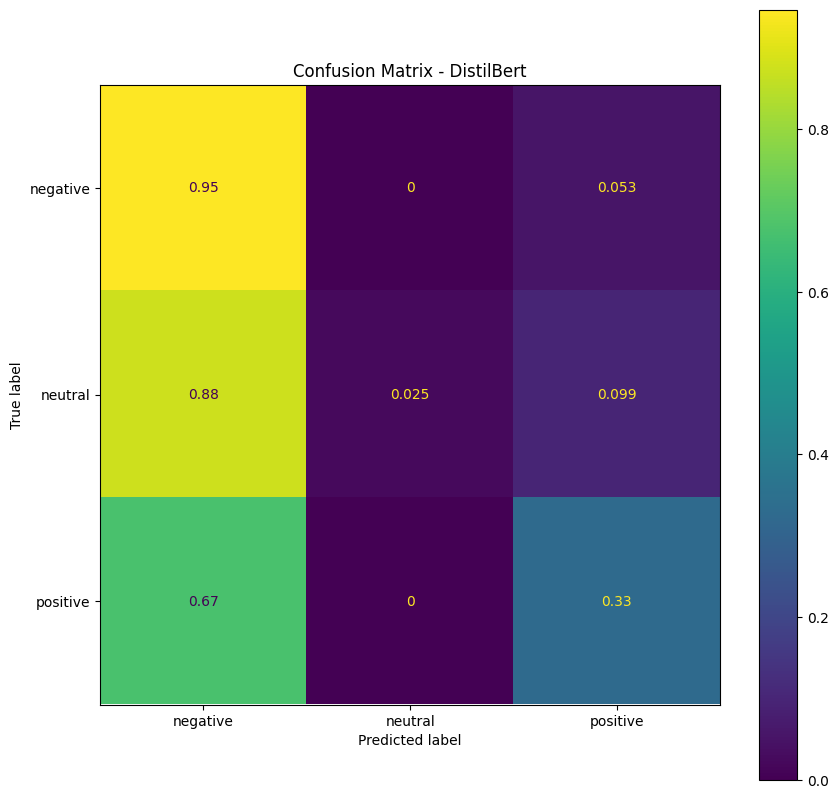

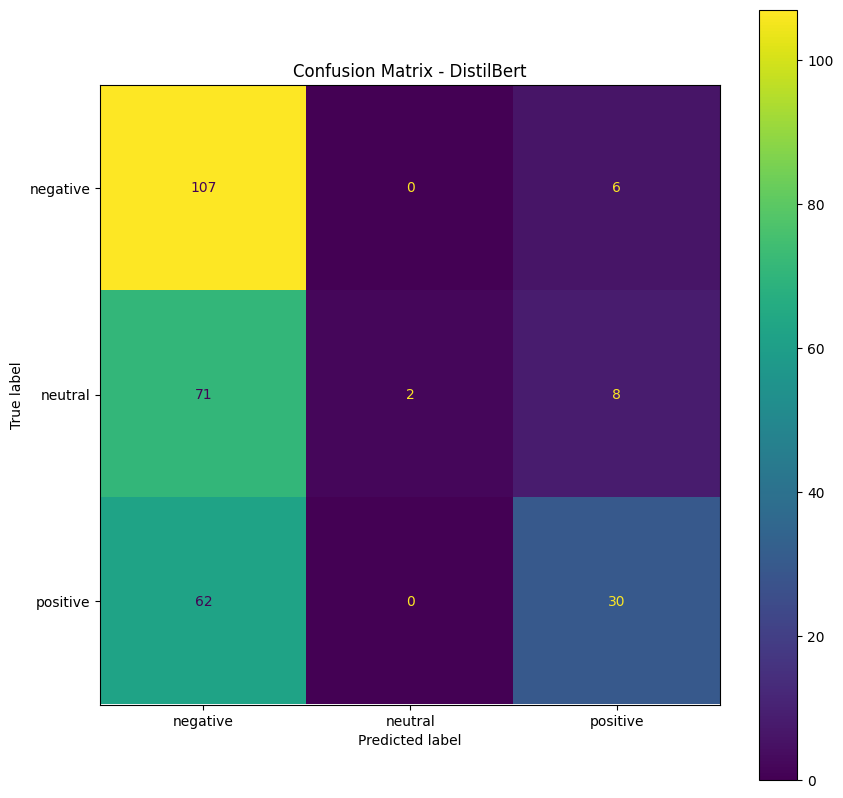

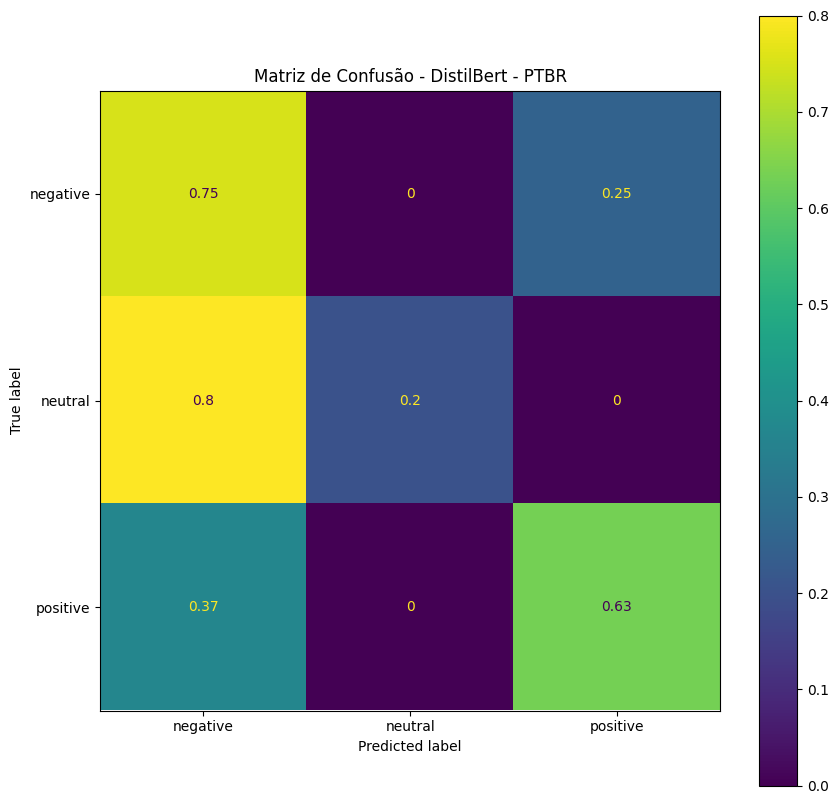

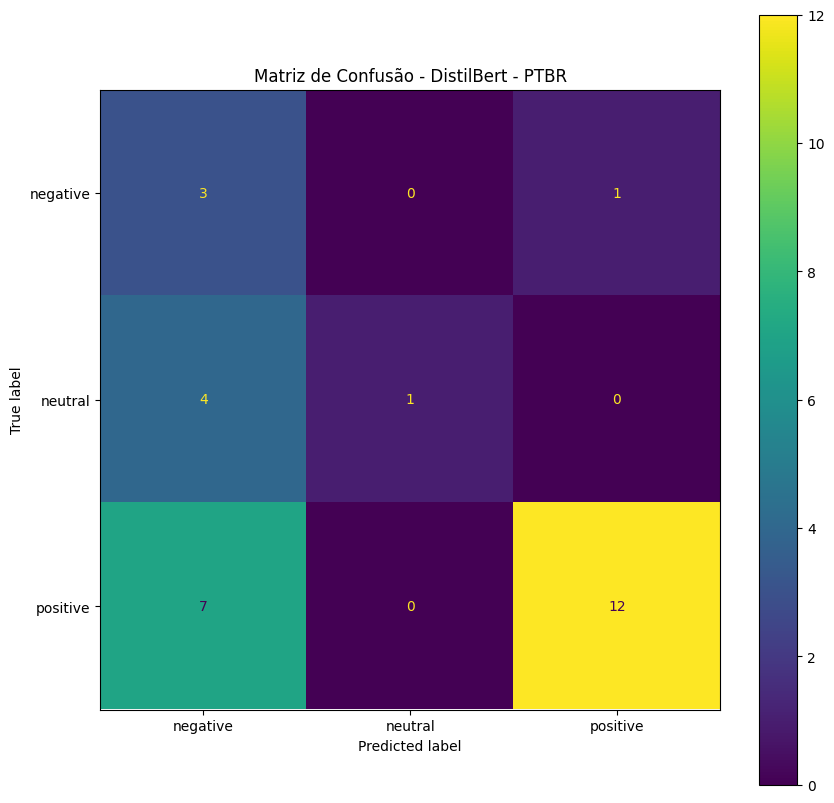

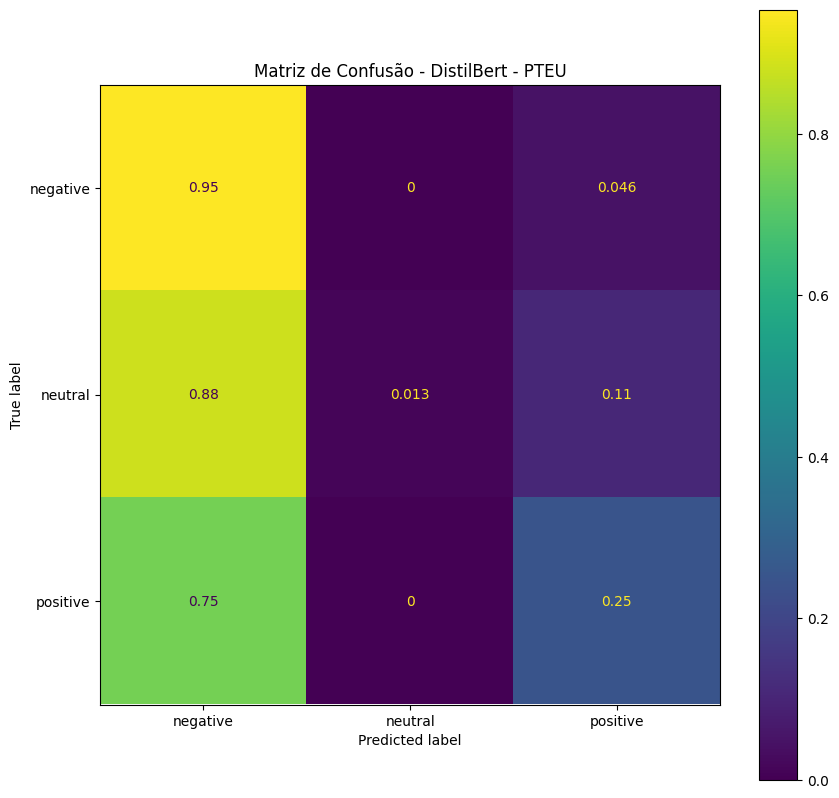

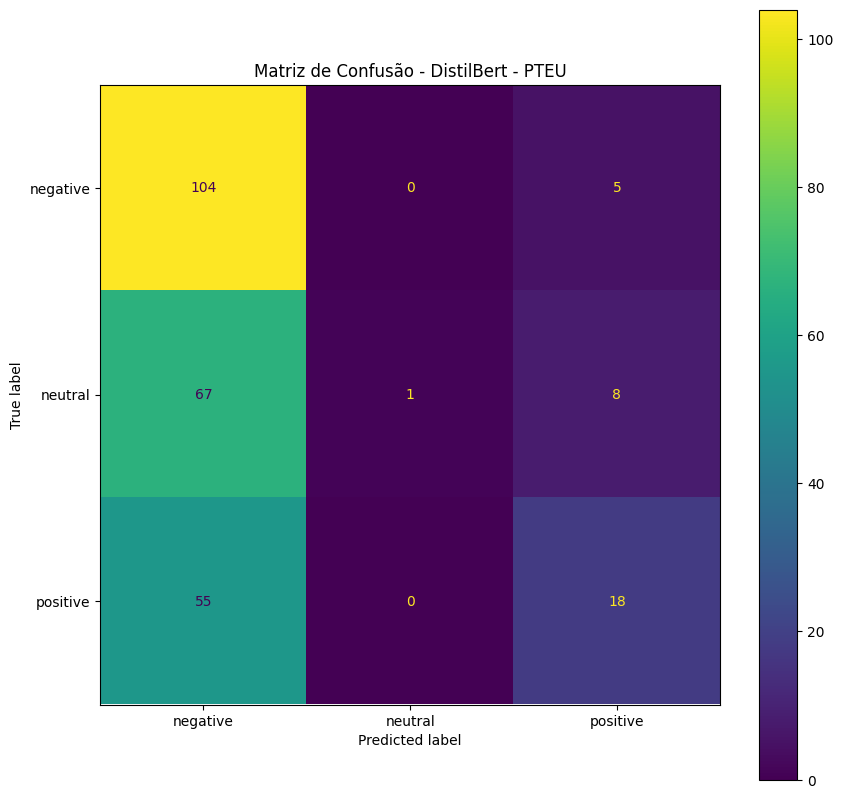

In [ ]:
#Distilbert

##pteu e ptbr
plotConfusionMatrix(labels["distilbert"], true_labels["mwes"], labels = target_names,
                    title="Confusion Matrix - DistilBert",
                    normalize=True,
                    path="conf_distilbert_norm.png")
plotConfusionMatrix(labels["distilbert"], true_labels["mwes"], labels = target_names,
                    title="Confusion Matrix - DistilBert",
                    normalize=False,
                    path="conf_distilbert.png")

##ptbr
plotConfusionMatrix(labels["distilbert_ptbr"],
                    true_labels["mwes_ptbr"],
                    labels = target_names,
                    title="Matriz de Confusão - DistilBert - PTBR",
                    path="conf_distilbert_ptbr_norm.png",
                    normalize=True)
plotConfusionMatrix(labels["distilbert_ptbr"],
                    true_labels["mwes_ptbr"],
                    labels = target_names,
                    title="Matriz de Confusão - DistilBert - PTBR",
                    path="conf_distilbert_ptbr.png",
                    normalize=False)

#pteu
plotConfusionMatrix(labels["distilbert_pteu"],
                    true_labels["mwes_pteu"],
                    labels = target_names,
                    title="Matriz de Confusão - DistilBert - PTEU",
                    path="conf_distilbert_pteu_norm.png",
                    normalize=True)
plotConfusionMatrix(labels["distilbert_pteu"],
                    true_labels["mwes_pteu"],
                    labels = target_names,
                    title="Matriz de Confusão - DistilBert - PTEU",
                    path="conf_distilbert_pteu.png",
                    normalize=False)

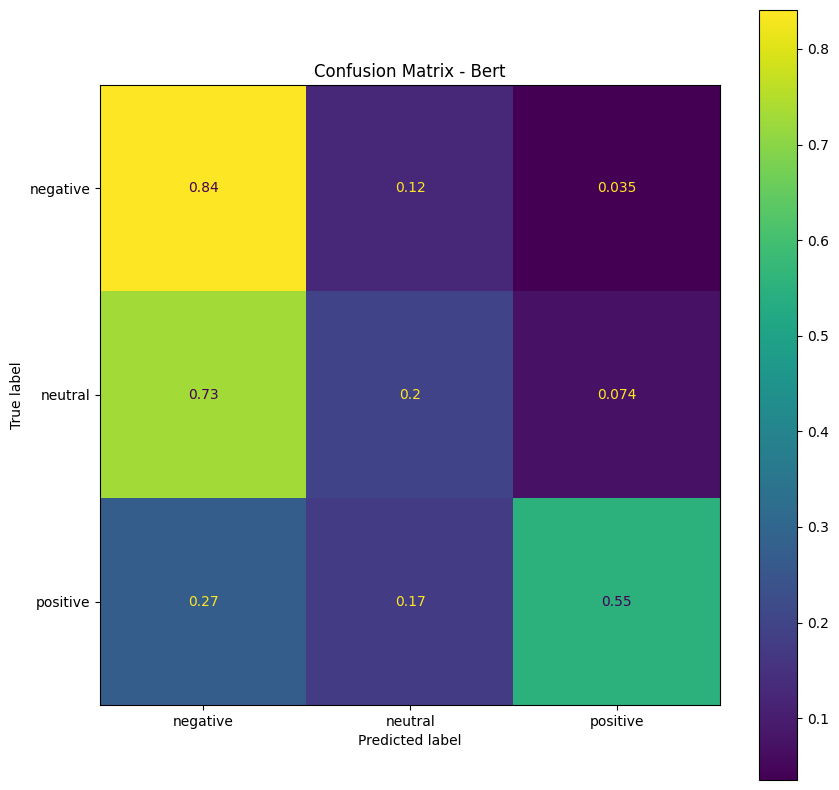

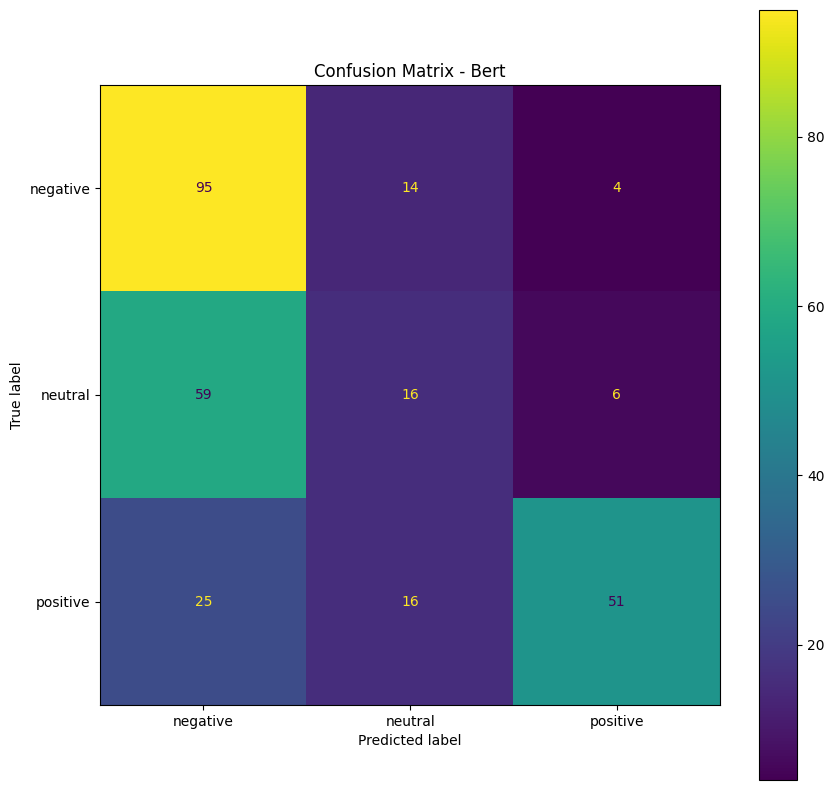

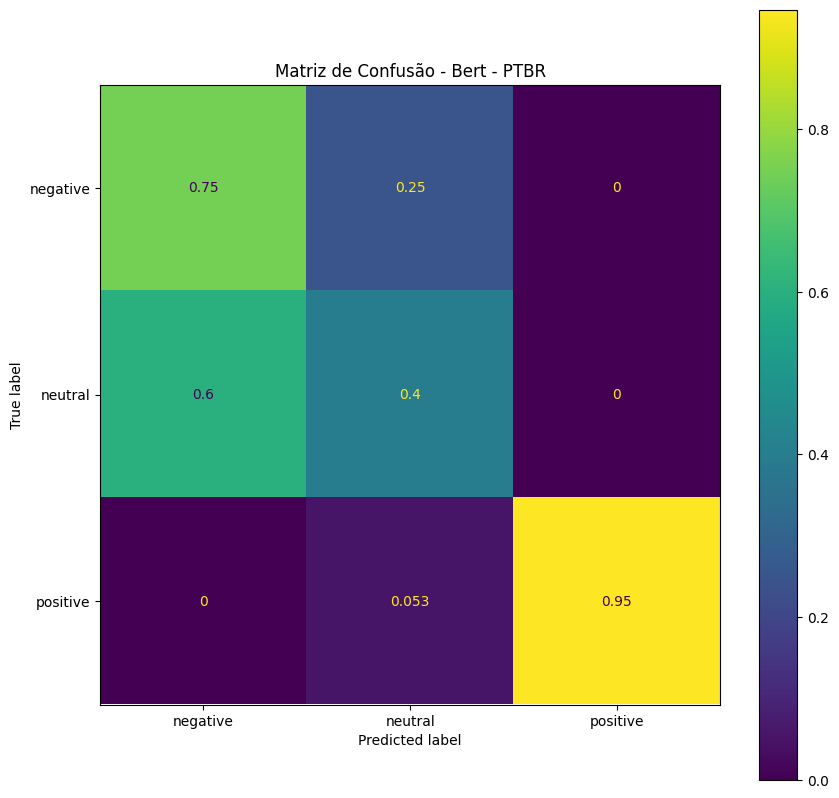

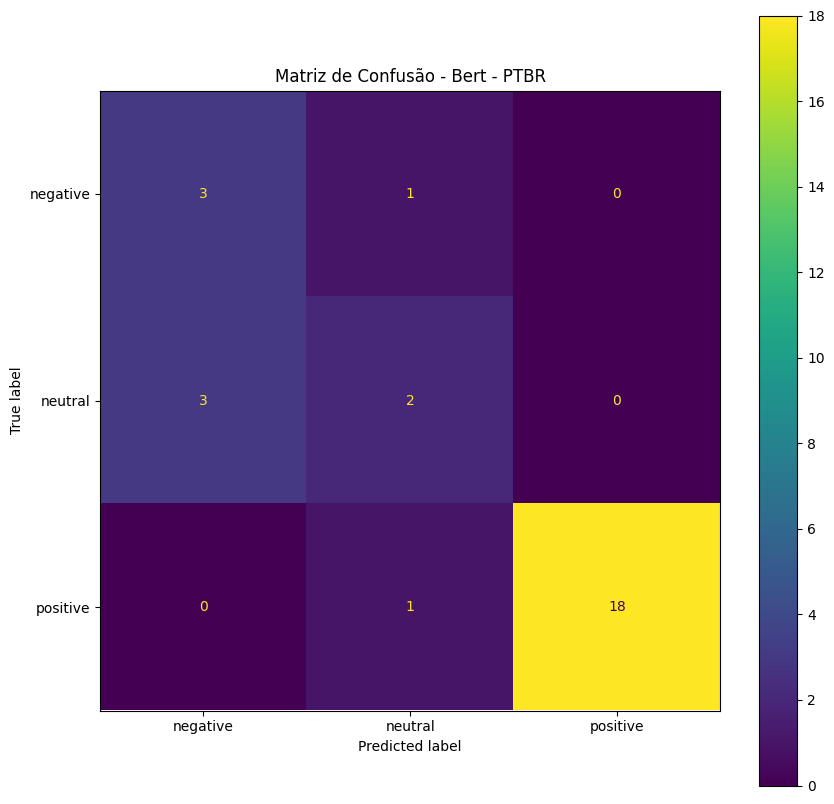

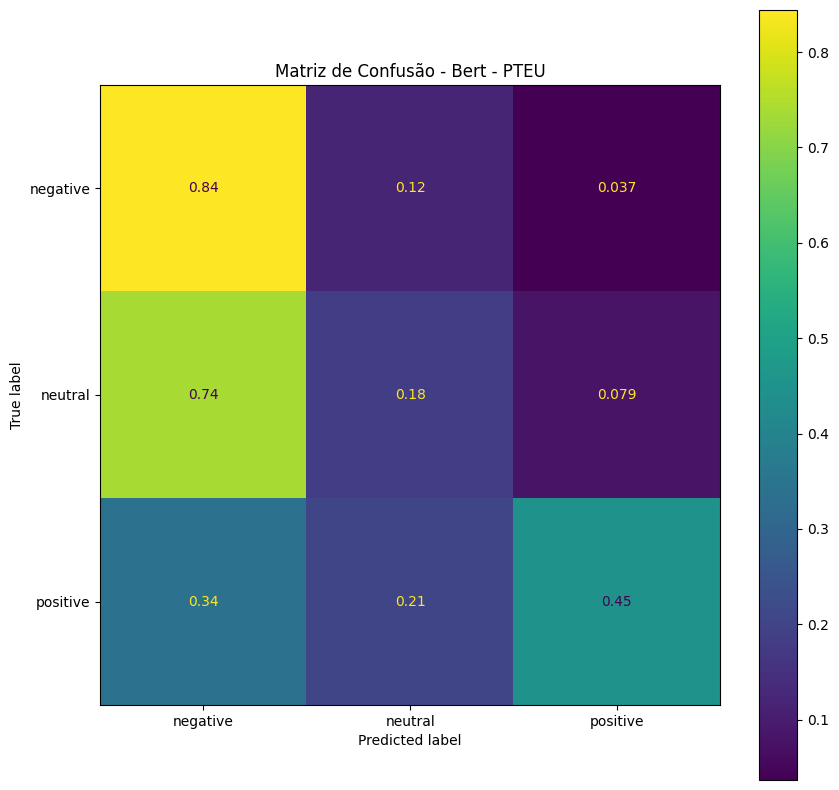

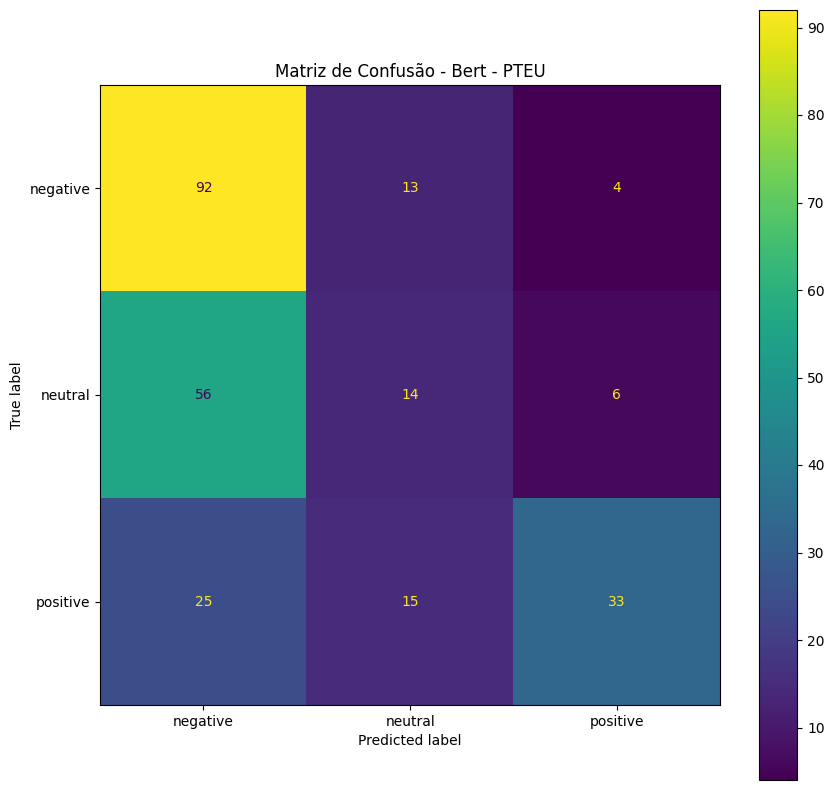

In [ ]:
#Bert

##ptpt e ptbr
plotConfusionMatrix(labels["bert"],
                    true_labels["mwes"],
                    labels = target_names,
                    title="Confusion Matrix - Bert",
                    path="conf_bert_norm.png",
                    normalize=True)
plotConfusionMatrix(labels["bert"],
                    true_labels["mwes"],
                    labels = target_names,
                    title="Confusion Matrix - Bert",
                    path="conf_bert.png",
                    normalize=False)

##ptbr
plotConfusionMatrix(labels["bert_ptbr"], true_labels["mwes_ptbr"],
                    labels = target_names,
                    title="Matriz de Confusão - Bert - PTBR",
                    path="conf_bert_ptbr_norm.png",
                    normalize=True)
plotConfusionMatrix(labels["bert_ptbr"], true_labels["mwes_ptbr"],
                    labels = target_names,
                    title="Matriz de Confusão - Bert - PTBR",
                    path="conf_bert_ptbr.png",
                    normalize=False)

##pteu
plotConfusionMatrix(labels["bert_pteu"],
                    true_labels["mwes_pteu"],
                    labels = target_names,
                    title="Matriz de Confusão - Bert - PTEU",
                    path="conf_bert_pteu_norm.png",
                    normalize=True)
plotConfusionMatrix(labels["bert_pteu"],
                    true_labels["mwes_pteu"],
                    labels = target_names,
                    title="Matriz de Confusão - Bert - PTEU",
                    path="conf_bert_pteu.png",
                    normalize=False)

_________________________________________________

## Versioning tracking

In [ ]:
!python --version

Python 3.12.12


In [ ]:
!pip list

Package                                  Version
---------------------------------------- --------------------
absl-py                                  1.4.0
accelerate                               1.12.0
access                                   1.1.9
affine                                   2.4.0
aiofiles                                 24.1.0
aiohappyeyeballs                         2.6.1
aiohttp                                  3.13.2
aiosignal                                1.4.0
aiosqlite                                0.21.0
alabaster                                1.0.0
albucore                                 0.0.24
albumentations                           2.0.8
ale-py                                   0.11.2
alembic                                  1.17.2
altair                                   5.5.0
annotated-types                          0.7.0
antlr4-python3-runtime                   4.9.3
anyio                                    4.11.0
anywidget                          